# Anomaly detection-risk based clustering classification, recall/precesion optimization with stacking models
<img src = 'https://images.unsplash.com/photo-1536390069759-2db770b49d77?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1500&q=80' width="500" height="200">

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [2]:
def summary(df) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes,
                       '결측치 수(null)' : df.isnull().sum(),
                       '결측치 비율(%)' : (df.isnull().sum()/len(df)).round(2),
                       '고유값 수(nunique)' : df.nunique(),
                      })
    for col in tf.index:
        tf.loc[col, '자료 내용(contents)'] = str(df[col].unique()[0:5])
        tf.loc[col, 'nan 비율'] = int(df[df[col] == 'nan'].shape[0]/len(df)*100)
        
    return tf

# Obtain data

In [4]:
df = pd.read_pickle('../../pkl/df_filtered-01.pkl')
df.shape
df.head(2)

(366385, 14)

,품목명,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,서류가공품,판매용,캐나다,1.238,아니오,아니오,아니오,해당없음,N,N,N,0,9.875088,10.088854
2,청주,판매용,일본,3.636,아니오,아니오,아니오,해당없음,N,N,N,0,10.162770,11.453674


# 1. 데이터 전처리
- 데이터전처리와 교차검증 분리
- SMOTE()적용을 위해 모든 특성변수는 수치화

In [5]:
summary(df)

,데이터형태(dtypes),결측치 수(null),결측치 비율(%),고유값 수(nunique),자료 내용(contents),nan 비율
품목명,object,0,0.0,166,['서류가공품' '청주' '소스류' '과실주' '만두류'],0.0
용도명,object,0,0.0,6,['판매용' '자사제품제조용' '외화획득용 원료' '판매용(식용향료)' '외화획득용...,0.0
제조국(원산지),object,0,0.0,84,['캐나다' '일본' '중국' '프랑스' '독일'],0.0
과세가격($/Kg),float64,0,0.0,49403,[1.238 3.636 2.004 5.733 4.54 ],0.0
유기식품 여부,object,0,0.0,2,['아니오' '예'],0.0
영유아섭취대상,object,0,0.0,2,['아니오' '예'],0.0
주문자상표부착,object,0,0.0,2,['아니오' '예'],0.0
유전자변형식품,object,0,0.0,3,['해당없음' '표시하지않음' '표시함'],0.0
가온보존대상,object,0,0.0,2,['N' 'Y'],0.0
진균수시험대상,object,0,0.0,2,['N' 'Y'],0.0


## Data Visualization

<AxesSubplot:>

Text(0.5, 1.0, '가공식품 제품유형별 수입신고 빈도(상위 50개 유형)')

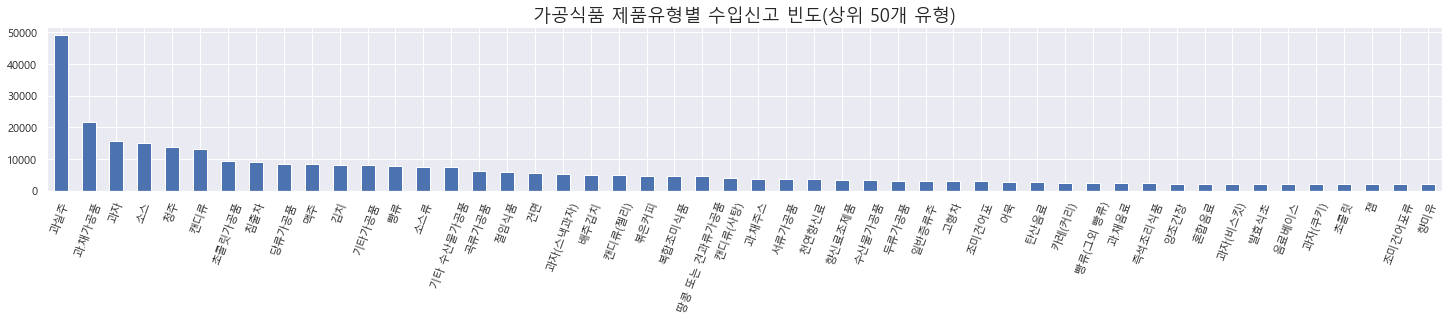

<AxesSubplot:>

Text(0.5, 1.0, '가공식품 제조국(원산지)별 수입신고 빈도(상위 50개국)')

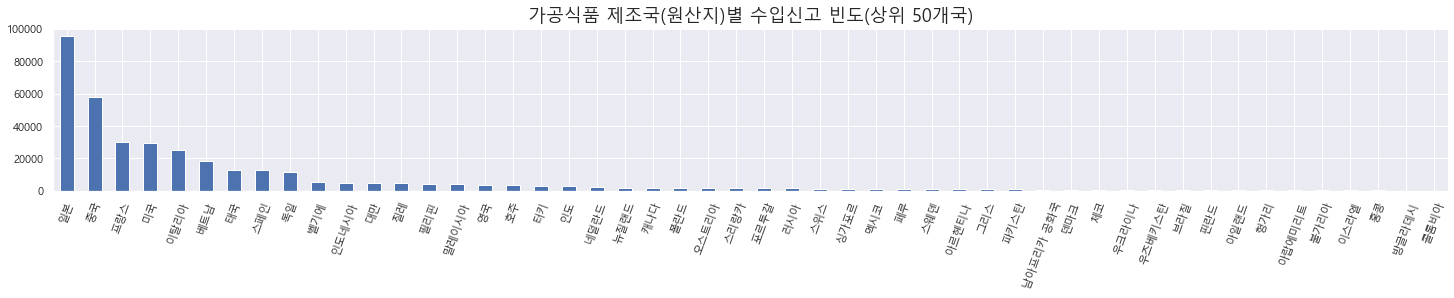

In [7]:
df.품목명.value_counts().nlargest(50).plot(kind='bar', figsize=(25, 3), rot=70)
plt.title('가공식품 제품유형별 수입신고 빈도(상위 50개 유형)', fontsize=18); plt.show()
df['제조국(원산지)'].value_counts().nlargest(50).plot(kind='bar', figsize=(25, 3), rot=70)
plt.title('가공식품 제조국(원산지)별 수입신고 빈도(상위 50개국)', fontsize=18)

## 실수형 변수
### 실수형 변수의 표준화(dynamic time warping을 적용하기 위해 minmax로 모든 변수를 0 ~ 1로 표준화)

In [8]:
df.columns

Index(['품목명', '용도명', '제조국(원산지)', '과세가격($/Kg)', '유기식품 여부', '영유아섭취대상', '주문자상표부착',
       '유전자변형식품', '가온보존대상', '진균수시험대상', '방사선조사식품', '판정결과', '순중량(Kg)_log',
       '과세가격_log'],
      dtype='object')

In [9]:
numeric_features = ['순중량(Kg)_log', '과세가격($/Kg)', '과세가격_log']

for col in numeric_features:
    df[col] = np.log(1 + df[col])
    
from sklearn.preprocessing import StandardScaler, MinMaxScaler
encoder = MinMaxScaler()
encoder.fit(df[numeric_features], df['판정결과'])
df[numeric_features] = encoder.transform(df[numeric_features])
#df[numeric_features].mean(); df[numeric_features].std()
df[numeric_features].min(); df[numeric_features].max()

MinMaxScaler()

순중량(Kg)_log    0.0
과세가격($/Kg)     0.0
과세가격_log       0.0
dtype: float64

순중량(Kg)_log    1.0
과세가격($/Kg)     1.0
과세가격_log       1.0
dtype: float64

array([[<AxesSubplot:title={'center':'순중량(Kg)_log'}>,
        <AxesSubplot:title={'center':'과세가격($/Kg)'}>],
       [<AxesSubplot:title={'center':'과세가격_log'}>, <AxesSubplot:>]],
      dtype=object)

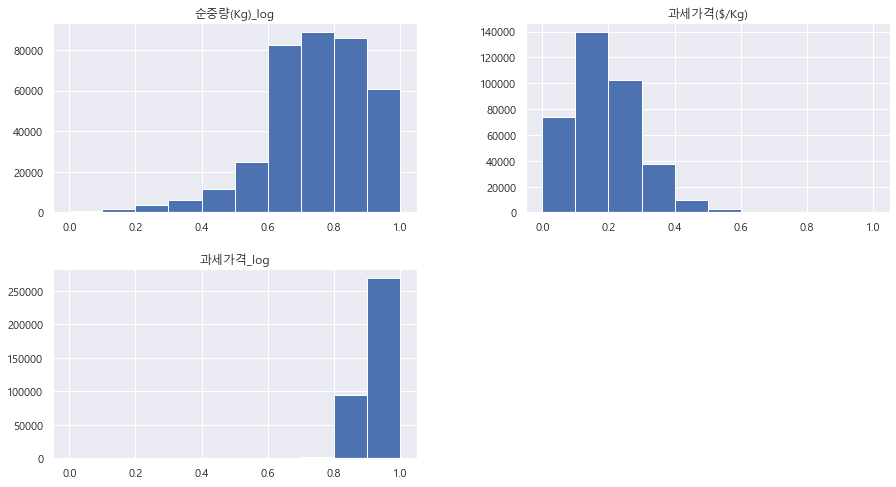

In [10]:
plt.rcParams['figure.figsize'] = [15,8]
df[numeric_features].hist()

## 범주형 변수
### Target mean

In [11]:
df.columns

Index(['품목명', '용도명', '제조국(원산지)', '과세가격($/Kg)', '유기식품 여부', '영유아섭취대상', '주문자상표부착',
       '유전자변형식품', '가온보존대상', '진균수시험대상', '방사선조사식품', '판정결과', '순중량(Kg)_log',
       '과세가격_log'],
      dtype='object')

In [12]:
categorical_features = ['품목명', '용도명', '제조국(원산지)', '유기식품 여부', '영유아섭취대상', '주문자상표부착',
                        '유전자변형식품', '가온보존대상', '진균수시험대상', '방사선조사식품']

In [13]:
import category_encoders as ce
encoder = ce.target_encoder.TargetEncoder(cols= categorical_features)
encoder.fit(df[categorical_features], df['판정결과'])
df[categorical_features] = encoder.transform(df[categorical_features])
df.head()
df.shape

TargetEncoder(cols=['품목명', '용도명', '제조국(원산지)', '유기식품 여부', '영유아섭취대상', '주문자상표부착',
                    '유전자변형식품', '가온보존대상', '진균수시험대상', '방사선조사식품'])

,품목명,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,0.010219,0.01083,0.011564,0.078144,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.935738,0.947442
2,0.000145,0.01083,0.000867,0.148788,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.948074,0.966289
3,0.009700,0.01083,0.014806,0.106698,0.010792,0.010825,0.010919,0.006059,0.010785,0.010653,0.01071,0,0.809270,0.913846
4,0.001284,0.01083,0.003169,0.184986,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.669704,0.893190
5,0.006593,0.01083,0.014806,0.166068,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.829100,0.933729


(366385, 14)

### Target 수치화

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_encoder = le.fit(df['판정결과'])
df['판정결과'] = label_encoder.transform(df['판정결과'])

# Step 1. 신속통관
## Unsupervised learning, Anomaly detection 

In [25]:
df = df.dropna()
df.isin([np.nan, np.inf, -np.inf]).any(1).sum()

0

In [26]:
tf =df.copy()
dummy_cats = tf.select_dtypes(include=['object', 'category']).columns
#tf = df.sample(frac=0.2)
X = pd.get_dummies(tf.drop(['판정결과'], axis=1), prefix=dummy_cats)
y = tf['판정결과']

In [27]:
df.shape

(366370, 14)

In [18]:
summary(X)

,데이터형태(dtypes),결측치 수(null),결측치 비율(%),고유값 수(nunique),자료 내용(contents),nan 비율
품목명,float64,0,0.0,164,[0.01021856 0.00014533 0.00969971 0.00128409 0...,0.0
용도명,float64,0,0.0,6,[0.01083048 0.01160464 0. 0.00051337 0...,0.0
제조국(원산지),float64,0,0.0,83,[0.0115636 0.00086712 0.01480569 0.00316884 0...,0.0
과세가격($/Kg),float64,0,0.0,46422,[0.07814373 0.14878786 0.10669766 0.18498626 0...,0.0
유기식품 여부,float64,0,0.0,2,[0.01079172 0.01225728],0.0
영유아섭취대상,float64,0,0.0,2,[1.08248858e-02 2.67653519e-05],0.0
주문자상표부착,float64,0,0.0,2,[0.01091869 0.00469653],0.0
유전자변형식품,float64,0,0.0,3,[0.01129468 0.00605879 0.0089636 ],0.0
가온보존대상,float64,0,0.0,2,[0.0107849 0.01847941],0.0
진균수시험대상,float64,0,0.0,2,[0.01065306 0.01994092],0.0


## 3.3 Elliptic(Multivariate gaussian distribution) based on PCA

Text(0.5, 0, '주성분 개 수')

Text(0, 0.5, '총변동량 누적 설명 비율')

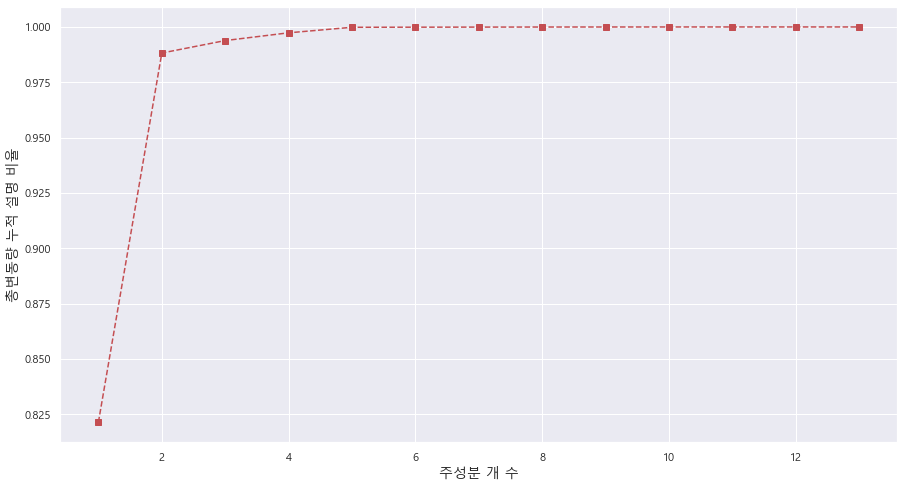

In [28]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.arange(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('주성분 개 수', fontsize='14'); plt.ylabel('총변동량 누적 설명 비율', fontsize='14')

In [30]:
X_pca = PCA(n_components=5).fit(X).transform(X)

from sklearn.covariance import EllipticEnvelope
el = EllipticEnvelope(contamination=y.mean())
el.fit(X_pca)

data = pd.DataFrame((df['판정결과'].values, el.decision_function(X_pca), el.predict(X_pca))).T

data.columns =['판정결과', '이상치', '이상치판정']
data

EllipticEnvelope(contamination=0.010822392663154734)

,판정결과,이상치,이상치판정
0,0.0,108.144417,1.0
1,0.0,103.439568,1.0
2,0.0,109.020311,1.0
3,0.0,108.023756,1.0
4,0.0,108.987118,1.0
...,...,...,...
366365,0.0,105.527158,1.0
366366,0.0,105.119049,1.0
366367,0.0,106.522238,1.0
366368,0.0,36.644658,1.0


array([[358865,   3540],
       [  3540,    425]], dtype=int64)

<AxesSubplot:>

recall: 10.718789407313997,  precision: 10.718789407313997
              precision    recall  f1-score   support

       적합(0)       0.99      0.99      0.99    362405
      부적합(1)       0.11      0.11      0.11      3965

    accuracy                           0.98    366370
   macro avg       0.55      0.55      0.55    366370
weighted avg       0.98      0.98      0.98    366370



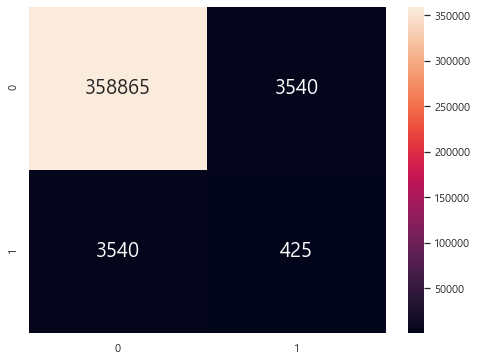

In [31]:
plt.rcParams['figure.figsize'] = [8,6]
data['y_pred']= data['이상치판정'].replace({1:0, -1:1})
data['y_true']= data['판정결과']

from sklearn.metrics import confusion_matrix
cm= confusion_matrix(data['y_true'], data['y_pred'])
cm
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})
tn, fp, fn, tp = confusion_matrix(data['y_true'], data['y_pred']).ravel()
print(f'recall: {(tp/(tp+fn)*100)},  precision: {(tp/(tp+fp)*100)}')

from sklearn.metrics import classification_report
target_names = ['적합(0)', '부적합(1)']
print(classification_report(data['y_true'], data['y_pred'], target_names=target_names))

## 3.4. Robust covariance estimation and Mahalanobis distances relevance¶
- https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.htmlm

In [32]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X_pca)

# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X_pca)

In [33]:
# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X_pca - np.mean(X_pca, 0)) ** (0.33)
# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X_pca - robust_cov.location_) ** (0.33)

data['emp_mahal'] = emp_mahal
data['robust_mahal'] = robust_mahal

In [34]:
n_outliers = data.판정결과.value_counts()[1]
n_outliers
n_samples = len(data)

3965

{'whiskers': [<matplotlib.lines.Line2D at 0x1749c02d4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1749c02dbb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1749c02d190>,
 'medians': [<matplotlib.lines.Line2D at 0x1749c0762b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1749c076610>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using non-robust estimates\n(Maximum Likelihood)')

{'whiskers': [<matplotlib.lines.Line2D at 0x1749c091d30>,
 'caps': [<matplotlib.lines.Line2D at 0x1749c0a5430>,
 'boxes': [<matplotlib.lines.Line2D at 0x1749c091a00>,
 'medians': [<matplotlib.lines.Line2D at 0x1749c0a5af0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1749c0a5e50>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using robust estimates\n(Minimum Covariance Determinant)')

{'whiskers': [<matplotlib.lines.Line2D at 0x1749c0c7580>,
 'caps': [<matplotlib.lines.Line2D at 0x1749c0c7c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1749c0c7220>,
 'medians': [<matplotlib.lines.Line2D at 0x1749c0bf340>,
 'fliers': [<matplotlib.lines.Line2D at 0x1749c0bf6a0>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Eliiptic. dist.)}}$')

Text(0.5, 1.0, 'Using Multivariate Gaussian Estimates\n(EllipticEnvelope)')

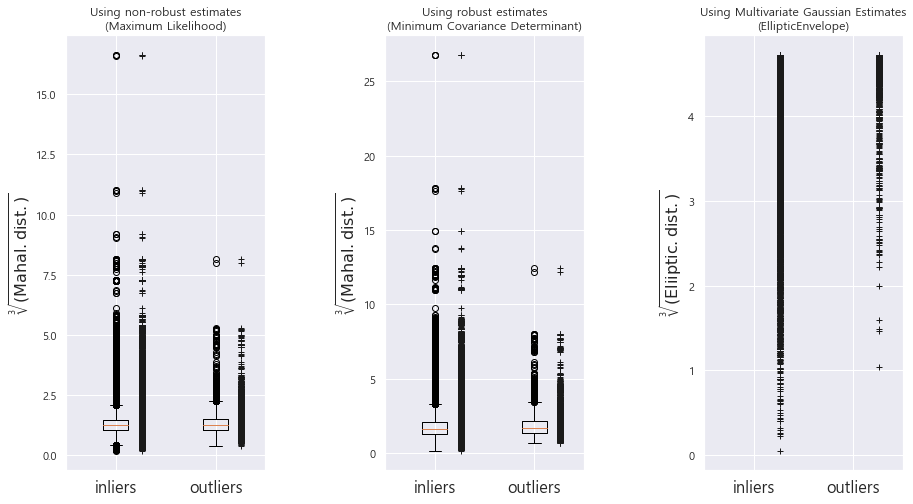

In [35]:
plt.rcParams['figure.figsize'] = [15,8]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.6)

# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X_pca - np.mean(X_pca, 0)) ** (0.33)
# Plot boxplots
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=0.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers], "+k", markeredgewidth=1,)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:], "+k", markeredgewidth=1)
ax1.axes.set_xticklabels(("inliers", "outliers"), size=16)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X_pca - robust_cov.location_) ** (0.33)
# Plot boxplots
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]], widths=0.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers], "+k", markeredgewidth=1,)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:], "+k", markeredgewidth=1)
ax2.axes.set_xticklabels(("inliers", "outliers"), size=16)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

# Calculate cubic root of Eclliptc distances for samples
eclliptic = el.decision_function(X_pca) ** (0.33)
# Plot boxplots
ax3.boxplot([eclliptic[:-n_outliers], eclliptic[-n_outliers:]], widths=0.25)
# Plot individual samples
ax3.plot(np.full(n_samples - n_outliers, 1.26), eclliptic[:-n_outliers], "+k", markeredgewidth=1,)
ax3.plot(np.full(n_outliers, 2.26), eclliptic[-n_outliers:], "+k", markeredgewidth=1)
ax3.axes.set_xticklabels(("inliers", "outliers"), size=16)
ax3.set_ylabel(r"$\sqrt[3]{\rm{(Eliiptic. dist.)}}$", size=16)
ax3.set_title("Using Multivariate Gaussian Estimates\n(EllipticEnvelope)")

plt.show()

## K-fold simulations for validating anomaly detection (k=10) : 생략
# 데이터 줄이기

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='판정결과', ylabel='emp_mahal'>

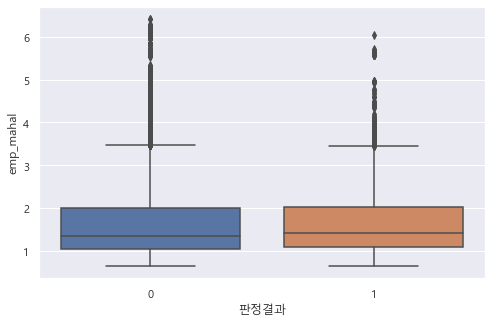

In [987]:
df['emp_mahal'] = emp_mahal
data= df[['판정결과', 'emp_mahal']]
plt.figure(figsize = (8, 5))
sns.boxplot(x='판정결과', y='emp_mahal', data=data)

In [988]:
oulier_max = df[df['판정결과'] == 1]['emp_mahal'].max()
df[df['emp_mahal'] <= oulier_max].shape
df.shape

(340272, 26)

(340417, 26)

In [669]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

NearestNeighbors(n_neighbors=3)

<AxesSubplot:>

Text(0.5, 1.0, 'Distance mean of KNN')

Text(0.5, 0, 'Instances')

Text(0, 0.5, 'Mean of Distance')

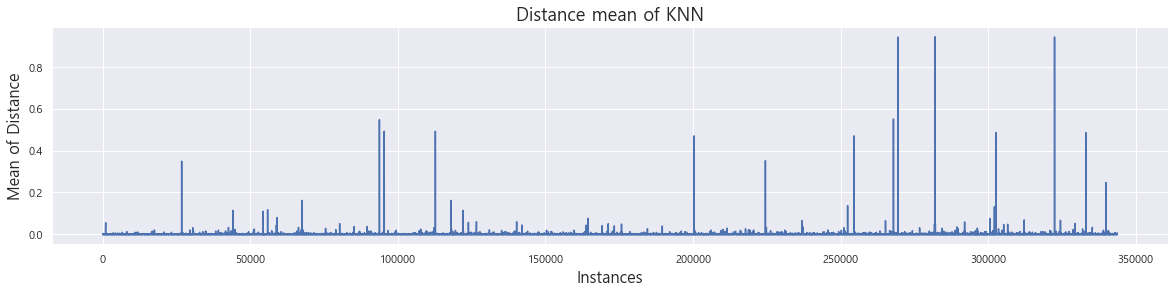

In [627]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 3) #algorithm='ball_tree'
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X) # distances : distances between data points
                                           # indices : associated index values
pd.Series(distances.mean(axis =1)).plot(figsize=(20,4))
plt.title('Distance mean of KNN', fontsize = 18)
plt.xlabel('Instances', fontsize = 16); plt.ylabel('Mean of Distance', fontsize = 16)

In [628]:
data

,weight,price,y_true
1,0.584052,0.570498,0
2,0.601069,0.647672,0
3,0.433011,0.453318,0
4,0.307402,0.392449,0
5,0.454098,0.519722,0
...,...,...,...
714383,0.555516,0.600263,0
714384,0.463213,0.570776,0
714387,0.252043,0.331410,0
714390,0.277402,0.457106,0


<AxesSubplot:xlabel='y_true', ylabel='weight'>

<AxesSubplot:xlabel='y_true', ylabel='price'>

<AxesSubplot:xlabel='y_true', ylabel='knn3_dist'>

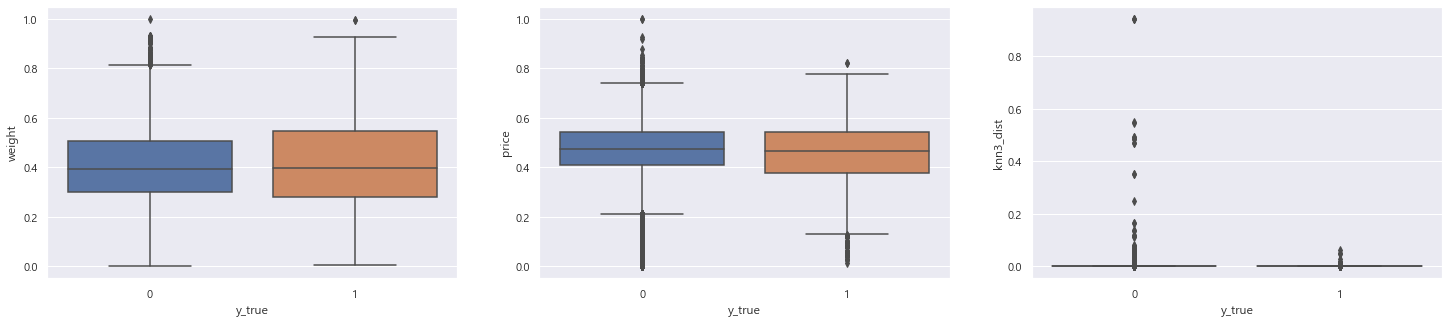

In [629]:
data['knn3_dist'] = distances.mean(axis =1)
cols= data.drop('y_true', axis=1).columns
fig, ax = plt.subplots(ncols=3, figsize=(25,5))
for i, col in enumerate(cols) :
    if i < 3:
        sns.boxplot(x= 'y_true', y= col, data=data, ax=ax[i])

In [630]:
nu_percentage= data['y_true'].value_counts(normalize=True).iloc[1]
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')

부적합율(훈련데이터:X_train)은 2.065427003254771 %


In [631]:
nbrsm = NearestNeighbors(algorithm='brute',  n_neighbors = 3, 
                      metric='mahalanobis', metric_params={'V': np.cov(X)})
nbrsm.fit(X)
distances, indices = nbrsm.kneighbors(X) # distances : distances between data points
                                           # indices : associated index values
pd.Series(distances.mean(axis =1)).plot(figsize=(20,4))
plt.title('Distance mean of KNN', fontsize = 18)
plt.xlabel('Instances', fontsize = 16); plt.ylabel('Mean of Distance', fontsize = 16)

MemoryError: Unable to allocate 881. GiB for an array with shape (343803, 343803) and data type float64

## Step 1. Low risk food clustering (신속통관)
### 이상치 점수가 어느 정도 이상 낮으면 정상이라고 판정

In [40]:
min_abonormal = data[data['y_true'] == 1]['anomaly_score'].min()
min_abonormal
data.loc[data['anomaly_score'] < min_abonormal, 'y_true'].sum()

-20.789788828604685

0

In [41]:
recalls =[]
precisions =[]
f1scores=[]
ratios=[]
thresholds=data['anomaly_score'].quantile(np.arange(0, 1, 0.05))
for threshold in thresholds:
    data['new_abnormal'] = 0
    data.loc[data['anomaly_score'] > threshold, 'new_abnormal'] = 1
    #confusion_matrix(data['y_true'], data['new_abnormal'])
    tn, fp, fn, tp = confusion_matrix(data['y_true'], data['new_abnormal']).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1score = 2*recall*precision/(recall+precision)
    ratio = (tp+fp)/(tn + fp + fn + tp)
    recalls.append(recall)
    precisions.append(precision)
    f1scores.append(f1score)
    ratios.append(ratio)
    print(f'임계값(Anomaly score): {threshold:.2f}, recall: {(tp/(tp+fn)*100):.3f}%,  precision: {(tp/(tp+fp)*100):.3f}%')

임계값(Anomaly score): -43.61, recall: 100.000%,  precision: 1.185%
임계값(Anomaly score): 7.36, recall: 90.798%,  precision: 1.133%
임계값(Anomaly score): 9.42, recall: 81.595%,  precision: 1.074%
임계값(Anomaly score): 10.26, recall: 77.301%,  precision: 1.078%
임계값(Anomaly score): 10.91, recall: 69.939%,  precision: 1.036%
임계값(Anomaly score): 11.42, recall: 63.190%,  precision: 0.998%
임계값(Anomaly score): 11.79, recall: 56.442%,  precision: 0.956%
임계값(Anomaly score): 12.11, recall: 50.920%,  precision: 0.928%
임계값(Anomaly score): 12.43, recall: 45.399%,  precision: 0.897%
임계값(Anomaly score): 12.70, recall: 42.945%,  precision: 0.925%
임계값(Anomaly score): 12.96, recall: 36.810%,  precision: 0.872%
임계값(Anomaly score): 13.20, recall: 33.129%,  precision: 0.872%
임계값(Anomaly score): 13.41, recall: 25.767%,  precision: 0.763%
임계값(Anomaly score): 13.58, recall: 20.245%,  precision: 0.686%
임계값(Anomaly score): 13.75, recall: 16.564%,  precision: 0.654%
임계값(Anomaly score): 13.91, recall: 12.883%,  precision:

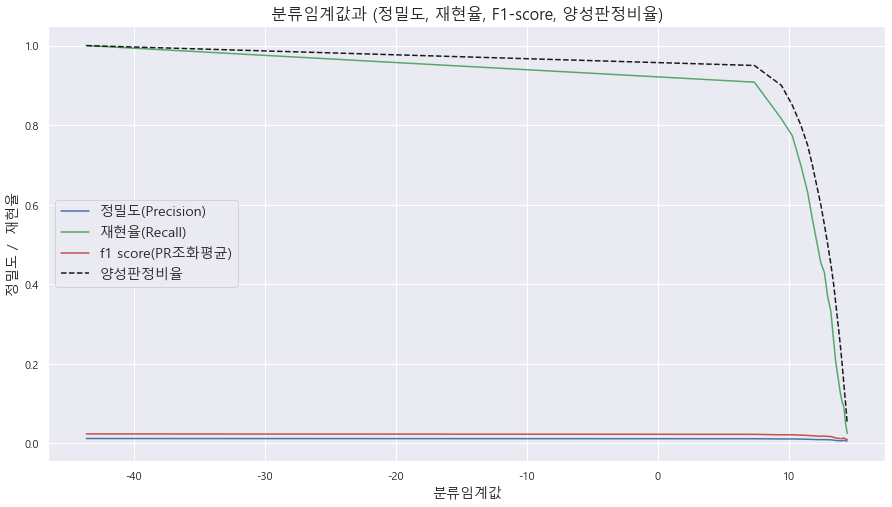

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, f1scores, ratios, thresholds): 
    plt.rcParams["figure.figsize"] = (15,8)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions, 'b-', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls, 'g-', label='재현율(Recall)') # 검사
    plt.plot(thresholds, f1scores, 'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, ratios, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(precisions, recalls, f1scores, ratios, thresholds)

<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb'>

### 2.1 이상치 탐색 with DTW
- 모든 특성변수는 자료표준화가 되어 0~1 사이의 값으로 존재하게 되어 dtw(dynamic time warping)거리fmf 기준으로 Anomaly detection
- https://en.wikipedia.org/wiki/Dynamic_time_warping
- https://dinhanhthi.com/dynamic-time-warping-dtw/

In [713]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
km.fit(X)
y_pred = km.fit_predict(X)
y_score = km.fit_transform(X)

KeyboardInterrupt: 

In [48]:
del data['new_abnormal']

In [49]:
data['y_pred_dtw'] = y_pred
data['y_normal_score_dtw'] = y_score[:, 0]
data['y_abnormal_score_dtw'] = y_score[:, 1]
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.203479,0.216251
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.332157,0.216861
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.582013,0.186103
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.512226,0.184541
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.160252,0.239185


In [50]:
data['y_normal_score_dtw'] = data['y_normal_score_dtw']/(data['y_normal_score_dtw'] + data['y_abnormal_score_dtw'])
data['y_abnormal_score_dtw']= data['y_abnormal_score_dtw']/(data['y_normal_score_dtw'] + data['y_abnormal_score_dtw'])
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


array([[7384, 6208],
       [ 105,   58]], dtype=int64)

<AxesSubplot:>

(7384, 6208, 105, 58)

recall: 0.3558282208588957,  precision: 0.00925630386211299


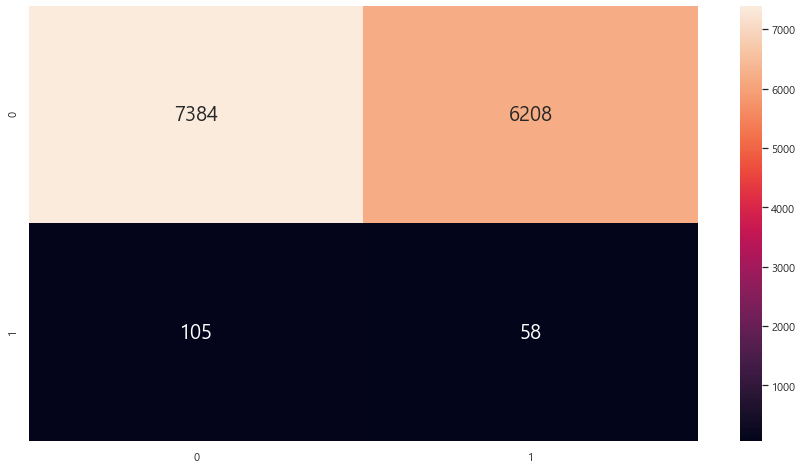

In [51]:
cm = confusion_matrix(data['y_true'], data['y_pred_dtw'])
cm
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})
tn, fp, fn, tp = confusion_matrix(data['y_true'], data['y_pred_dtw']).ravel()
tn, fp, fn, tp 
print(f'recall: {tp/(tp+fn)},  precision: {tp/(tp+fp)}')

In [52]:
from sklearn.metrics import classification_report
target_names = ['적합(0)', '부적합(1)']
print(classification_report(data['y_true'], data['y_pred_dtw'], target_names=target_names))

              precision    recall  f1-score   support

       적합(0)       0.99      0.54      0.70     13592
      부적합(1)       0.01      0.36      0.02       163

    accuracy                           0.54     13755
   macro avg       0.50      0.45      0.36     13755
weighted avg       0.97      0.54      0.69     13755



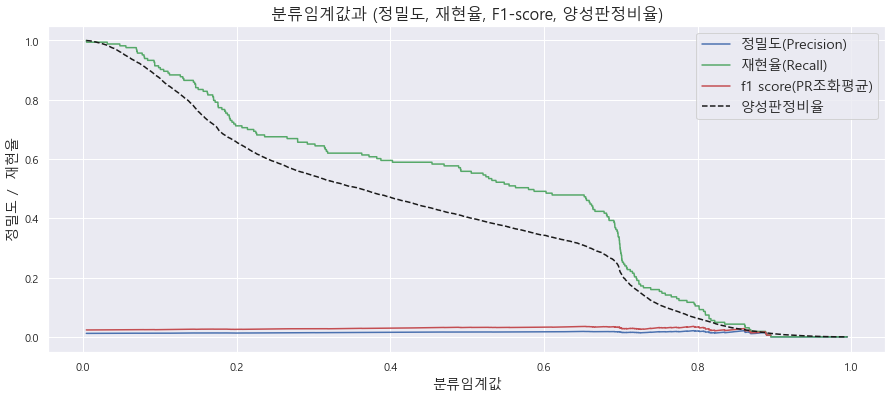

In [53]:
from sklearn.metrics import precision_recall_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
p, r, thresholds = precision_recall_curve(data['y_true'], data['y_abnormal_score_dtw'])

scores = [np.sum(to_labels(data['y_abnormal_score_dtw'], t))/len(data) for t in thresholds]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.rcParams["figure.figsize"] = (15,6)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b-', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율(Recall)') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, scores, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(p, r, thresholds)

In [56]:
data

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505
...,...,...,...,...,...,...,...,...,...
1749366,0.708465,0.707741,0,0.002485,14.135439,0,1,0.817237,0.081982
680175,0.544920,0.613473,0,0.002243,14.460331,0,0,0.347306,0.427472
1132812,0.767909,0.792084,0,0.015411,13.443363,0,1,0.929820,0.033083
2079622,0.413452,0.608788,0,0.006656,13.402480,0,0,0.128812,0.745248


<AxesSubplot:xlabel='y_normal_score_dtw', ylabel='y_abnormal_score_dtw'>

<AxesSubplot:xlabel='y_normal_score_dtw', ylabel='y_abnormal_score_dtw'>

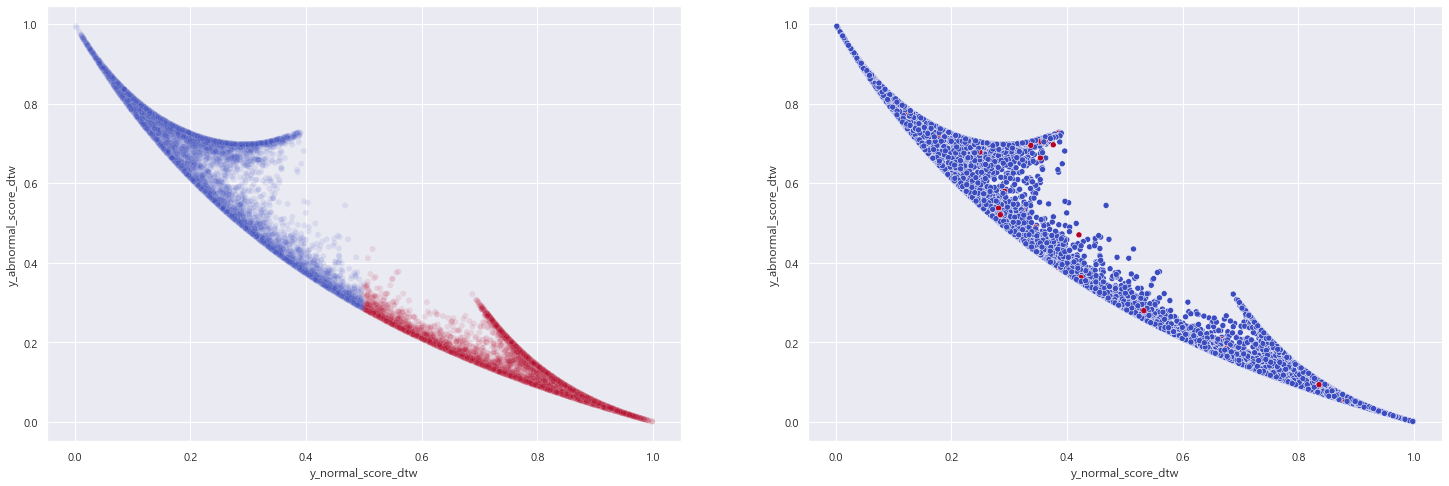

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(25,8))
sns.scatterplot(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_pred_dtw'],
                cmap = 'coolwarm', alpha=0.1, ax=ax[0])
sns.scatterplot(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_true'],
                cmap = 'coolwarm', ax=ax[1])

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'normal_score')

Text(0, 0.5, 'anomaly_score')

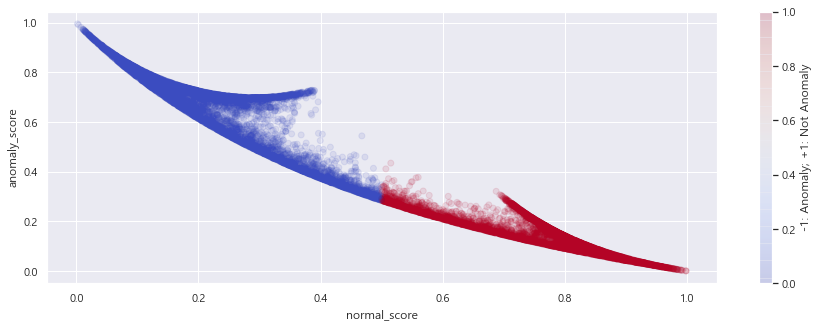

In [81]:
plt.figure(figsize = (15, 5))
ax = plt.scatter(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_pred_dtw'], 
                 cmap = 'coolwarm', alpha=0.1)
plt.xlabel('normal_score'); plt.ylabel('anomaly_score')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

Text(0.5, 0, 'normal_score')

Text(0, 0.5, 'anomaly_score')

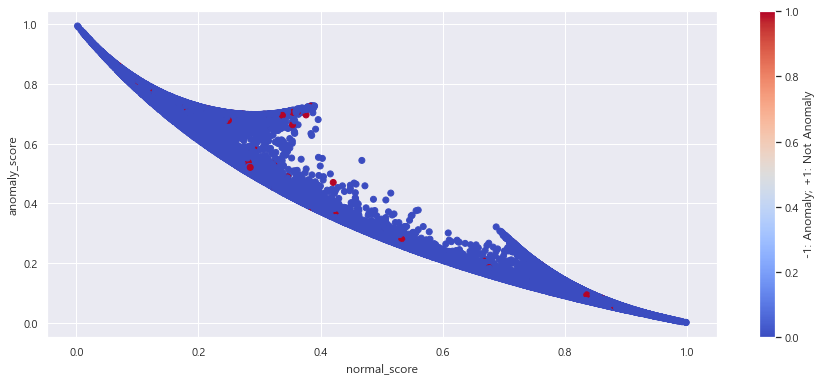

In [82]:
ax = plt.scatter(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_true'], 
                 cmap = 'coolwarm')
plt.xlabel('normal_score'); plt.ylabel('anomaly_score')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

In [83]:
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


Text(0.5, 1.0, '이상치 점수와 적합부적합')

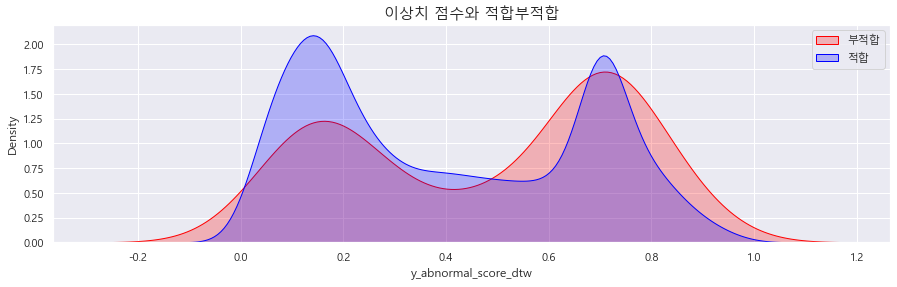

In [84]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(data.loc[data['y_true'] == 1, 'y_abnormal_score_dtw'], color='red', shade=True, label='부적합')
ax=sns.kdeplot(data.loc[data['y_true'] == 0, 'y_abnormal_score_dtw'], color='blue', shade=True, label='적합')
plt.legend()
plt.title('이상치 점수와 적합부적합', fontsize =15)

### 부적합 판정결과의 이상치수치가 upper/lower limit 이상이하인 데이터는 제외

<AxesSubplot:xlabel='y_true', ylabel='y_abnormal_score_dtw'>

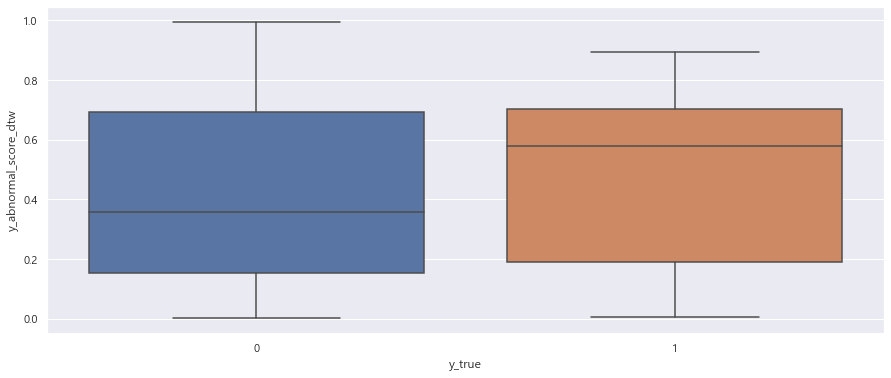

In [85]:
sns.boxplot(x = "y_true", y = "y_abnormal_score_dtw", data = data)

In [86]:
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


In [87]:
data['y_abnormal_score_dtw'].max()

0.9946735431278282

In [88]:
data[data['y_abnormal_score_dtw'] > max_abonormal]['y_true'].sum()
data[data['y_normal_score_dtw'] > max_abonormal]['y_true'].sum()

0

3

In [89]:
max_abonormal = data[data['y_true'] == 1]['y_abnormal_score_dtw'].max()
max_abonormal
data.loc[data['y_normal_score_dtw'] > max_abonormal, 'y_true']
data.loc[data['y_normal_score_dtw'] > max_abonormal, 'y_true'].sum()

0.8951169432586579

2042872    0
2225070    0
2920555    0
821603     0
1658680    0
          ..
67363      0
350463     0
310402     0
246097     0
1132812    0
Name: y_true, Length: 561, dtype: int64

3

In [16]:
index = data[~((data['y_score_0'] < l_fence) | (data['y_score_0'] > u_fence))].index

In [17]:
index

Int64Index([2225054,  255568,  130945, 2089969,  193189,  705775, 1841778,
            1555938,  134428,  506178,
            ...
            1629433, 1173186,  966207, 2994311, 2117330, 1878562, 1761179,
             194046, 2441814,  923283],
           dtype='int64', length=68551)

### Algorithm selection for Anomaly Detection
- https://medium.com/analytics-vidhya/algorithm-selection-for-anomaly-detection-ef193fd0d6d1
<img src= 'https://miro.medium.com/max/1072/1*OIXCo35Vvzr9qoUbV2fHMA.png'>

### <font color='brown'> Unsupervised learning anomaly detection methods
<img src='https://miro.medium.com/max/1540/1*7yJ2KiW3RFHP2nJppTP4mw.png'>

# 3. 지도학습 예측
- 이상치 score로 downsizing된 데이터를 만든다

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report

In [24]:
data = df[df.index.isin(index)]
data.shape
data.head()

(68551, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
2225054,즉석조리식품,판매용,인도네시아,3.647,아니오,아니오,아니오,표시함,N,N,N,0,6.546785,7.839526
255568,배추김치,판매용,중국,0.460,아니오,아니오,아니오,해당없음,N,N,N,0,8.987322,8.210940
130945,과실주,판매용,호주,11.692,아니오,아니오,아니오,해당없음,N,N,N,0,6.916715,9.374673
2089969,기타 수산물가공품,판매용,베트남,5.400,아니오,아니오,아니오,표시함,N,N,N,0,9.287394,10.973718
193189,과실주,판매용,프랑스,2.333,아니오,아니오,아니오,해당없음,N,N,N,0,8.412055,9.259226


- 훈련/검증 데이터 분리

In [25]:
X = data.drop('판정결과', axis=1)
y = data['판정결과']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [38]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())])
        
    grid_search = RandomizedSearchCV(pipe, {}, 
                                     scoring='recall', 
                                     refit = refit_score,
                                     cv = skf, 
                                     return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_test, y_pred))
    
    return grid_search

In [43]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     13539        13
pos       157         2
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13552
           1       0.13      0.01      0.02       159

    accuracy                           0.99     13711
   macro avg       0.56      0.51      0.51     13711
weighted avg       0.98      0.99      0.98     13711



# 3. Oversampling 예측
- recall 이 높은 알고리즘 선택

In [44]:
from imblearn.under_sampling import *
from imblearn.pipeline import Pipeline, make_pipeline  # scikit-learn의 pipeline을 사용하지 마라!

In [45]:
randomseed = 1024

def classification_result_imbalance(imbalance_method=RandomUnderSampler(random_state=randomseed), refit_score='recall_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('imbalance sampler', imbalance_method),
        ('classifier', RandomForestClassifier())])
    
    smote_pipeline = make_pipeline(preprocessor,
                                   imbalance_method,
                                   RandomForestClassifier())
    
    grid_search = RandomizedSearchCV(smote_pipeline, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))  
    return grid_search

In [47]:
under_sampling_methods = [RandomUnderSampler(random_state=randomseed)]

for mine in under_sampling_methods:
    mine
    grid_search_clf = classification_result_imbalance(imbalance_method=mine, refit_score='recall_score')

RandomUnderSampler(random_state=1024)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     13552
           1       0.03      0.74      0.06       159

    accuracy                           0.74     13711
   macro avg       0.51      0.74      0.46     13711
weighted avg       0.98      0.74      0.84     13711



# End

#  2. Semi-Supervised learning (Novelty detection)
## One-class SVM with non-linear kernel (RBF)
- OCSVM assumes that anomalies can form dense clusters as long as they form a low-density region in the training dataset.
- OCSVM mode is trained in only one class, referred to as the normal class. The model learns all the features and patterns of the normal class 
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

#### <p> <font color= 'blue'> Intuition : One-class SVM is based on SVM, which uses a hyperplane to seperate two classes while a  <b>One-class SVM uses a hypersphere to emcompass all of the observations<b> <p>

In [105]:
df= tf.copy()
train_rec_count=int(len(df)*.8)
df_train= df.iloc[:train_rec_count,:]
df_train.shape
df_train.head()
df_train['판정결과'].value_counts(normalize=True)

(11004, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1663960,0.000000,0.011355,0.001769,0.000500,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.568702,0.664566
2312845,0.008032,0.011355,0.001769,0.000375,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.472120,0.553561
2205920,0.017202,0.018927,0.001769,0.000421,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.828743,0.881663
1644698,0.011173,0.011355,0.009709,0.000278,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.335609,0.405416
2063361,0.010169,0.011355,0.001769,0.000494,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.396945,0.510000


0    0.987732
1    0.012268
Name: 판정결과, dtype: float64

In [107]:
df_test=df.iloc[train_rec_count:,:]
df_test.shape
df_test.head()
df_test['판정결과'].value_counts(normalize=True)

(2751, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1787451,0.000000,0.011355,0.006404,0.003122,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.379082,0.652285
2322748,0.000000,0.011355,0.006404,0.000424,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.512088,0.599961
383035,0.000000,0.011355,0.000000,0.000246,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.734091,0.751004
1851180,0.008032,0.011355,0.001769,0.001867,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.556829,0.767218
350816,0.000000,0.011355,0.001769,0.001948,0.011347,0.011487,0.011562,0.012078,0.011502,0.027950,0.011459,0,0.391934,0.623295


0    0.991639
1    0.008361
Name: 판정결과, dtype: float64

### 정상과 비정상이 있는 훈련데이터(X_train, y_train)

In [108]:
X_train= df_train.drop('판정결과', axis=1)
y_train= df_train['판정결과']
y_train.value_counts(normalize=True)
X_train.shape, y_train.shape

0    0.987732
1    0.012268
Name: 판정결과, dtype: float64

((11004, 13), (11004,))

### 검증데이터(X_test)

In [109]:
X_test= df_test.drop('판정결과', axis=1)
y_test= df_test['판정결과']
y_test.value_counts(normalize=True)
X_test.shape, y_test.shape

0    0.991639
1    0.008361
Name: 판정결과, dtype: float64

((2751, 13), (2751,))

### Creating the One-Class Support Vector Macine

In [110]:
nu_percentage= df_train['판정결과'].value_counts(normalize=True).iloc[1]
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')

부적합율(훈련데이터:X_train)은 1.2268266085059978 %


In [111]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(nu=nu_percentage) # OneClassSVM(kernel='rbf', nu=0.0005, gamma=0.007)

In [127]:
ocsvm.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.012268266085059978,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## 2.1. 지도학습 : 지도학습후 예측결과(yhat)와 실제자료(df_test)와 비교 

In [119]:
df_test.판정결과.value_counts()
df_test.onesvm_anomaly.value_counts()

0    2728
1      23
Name: 판정결과, dtype: int64

 1    2721
-1      30
Name: onesvm_anomaly, dtype: int64

OneClassSVM(nu=0.012268266085059978)

<AxesSubplot:>

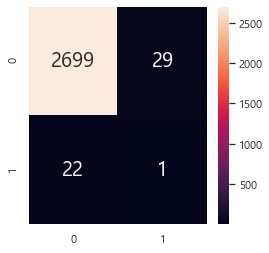

In [125]:
ocsvm.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix

yhat=ocsvm.predict(X_test)

df_test['onesvm_anomaly']= yhat
df_test['onesvm_anomaly'] = df_test['onesvm_anomaly'].replace({1:0,-1:1})

cm=confusion_matrix(df_test['판정결과'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})

In [126]:
from sklearn.metrics import classification_report
target_names = ['Normal(1)', 'Abnormal(-1)']
print(classification_report(df_test['판정결과'], df_test['onesvm_anomaly'], target_names=target_names))

              precision    recall  f1-score   support

   Normal(1)       0.99      0.99      0.99      2728
Abnormal(-1)       0.03      0.04      0.04        23

    accuracy                           0.98      2751
   macro avg       0.51      0.52      0.51      2751
weighted avg       0.98      0.98      0.98      2751



In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(" Accuracy Score for One-Class SVM :", accuracy_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Precision for One-Class SVM :", precision_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Recall for One-Class SVM :", recall_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Confusion Matrix: \n", cm)

 Accuracy Score for One-Class SVM : 0.9814612868047983
 Precision for One-Class SVM : 0.03333333333333333
 Recall for One-Class SVM : 0.043478260869565216
 Confusion Matrix: 
 [[2699   29]
 [  22    1]]


## 2.2. 비지도학습 훈련

In [ ]:
ocsvm = OneClassSVM(nu=nu_percentage)
ocsvm.fit(X_train)

<AxesSubplot:>

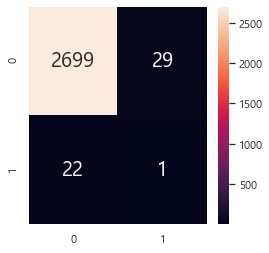

In [132]:
yhat=ocsvm.predict(X_test)

df_test['onesvm_anomaly']= yhat
df_test['onesvm_anomaly'] = df_test['onesvm_anomaly'].replace({1:0,-1:1})
cm=confusion_matrix(df_test['판정결과'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})

## 2.3. 준지도학습 훈련